Name: Minamedez, Gabriel Nicolas D.

# Neural Networks Exercise

In the previous exercises, you implemented linear models for regression and multi-class classification. In this exercise, you will combine those ideas to create neural networks with arbitrary number of layers to perform multi-class classification, also called multi-layered perceptrons.

**You will learn to:**
- Compute Numerical Gradients to be used as gradient checkers
- Build the general architecture of a Neural Network Model consisting of fully connected layers.
    - Initializing Parameters/Weights of each layer
    - Implement the forward pass
        - forward pass of fully connected layers
        - forward pass of sigmoid activation function
        - forward pass of tanh activation function
        - forward pass of ReLU activation function
    - Implement the backward pass to compute for gradients
        - backward pass of fully connected layers
        - backward pass of sigmoid activation function
        - backward pass of tanh activation function
        - backward pass of ReLU activation function
    - Calculating the Cost/Loss/Objective Function
    - Implement gradient descent to update the paramters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Fix the seed of the random number 
# generator so that your results will match ours
np.random.seed(1)

%load_ext autoreload
%autoreload 2

# Numerical Gradient
We will be stacking multiple layers on top of one another to generate more complex hypothesis functions. Solving for the analytical gradients of each layer's parameters is no longer trivial and will be prone to errors. Fortunately, there is an easy way to compute gradients numerically. It is very slow to be used to train neural networks but it is very useful in debugging our analytically derived gradients.

**Open `gradient_checker.py`, and implement `compute_numerical_gradient`.**

In [3]:
from gradient_checker import compute_numerical_gradient, relative_error
np.random.seed(1)

# creates a dummy loss function
def dummy_loss_function(X, y, W):
    N, D = X.shape
    loss = 0.5 * np.mean((X.dot(W) - y)**2)
    
    grad = {}
    grad['W'] = np.dot(X.T, X.dot(W) - y) / N
    
    return loss, grad

X_dummy = np.random.randn(3,5)
y_dummy = np.random.randn(3,1)
W_dummy = np.random.randn(5,1)

# solves for the analytical gradient.
loss, grad = dummy_loss_function(X_dummy,y_dummy,W_dummy)

# lambda functions are anonymous functions defined without a name. We use this to
# pass in a function that has only W as its parameter and everything else is fixed. 
# Since the compute_numerical_gradient expects a function that outputs a scalar value,
# we return only the first element which corresponds to the loss value
numerical_gradients = compute_numerical_gradient(lambda W: dummy_loss_function(X_dummy, y_dummy, W)[0], W_dummy)

print("Analytical Gradients")
print(grad['W'])

print("Numerical Gradients")
print(numerical_gradients)

print("Relative Error")
print(relative_error(grad['W'], numerical_gradients))

Analytical Gradients
[[-0.74692649]
 [ 0.54694129]
 [-0.76442224]
 [-0.2044723 ]
 [ 0.35616946]]
Numerical Gradients
[[-0.74692649]
 [ 0.54694129]
 [-0.76442224]
 [-0.2044723 ]
 [ 0.35616946]]
Relative Error
1.639804271286896e-11


**Sanity Check:**
    
Expected Output
```
Analytical Gradients
[[-0.74692649]
 [ 0.54694129]
 [-0.76442224]
 [-0.2044723 ]
 [ 0.35616946]]
Numerical Gradients
[[-0.74692649]
 [ 0.54694129]
 [-0.76442224]
 [-0.2044723 ]
 [ 0.35616946]]
Relative Error
1.63980427129e-11
```

# Data
We will first use a toy dataset, so we can visualize our data and model's predictions in 2D. Below are two functions that generates circular data and spiral data, both of which are not linearly separable. We will use the circle data by default but feel free to experiment with the spiral data as well.

In [4]:
def generate_dummy_circle_data(num_points):
    r = np.random.uniform(0,2,num_points)
    theta = np.random.uniform(0,2*np.pi,num_points)
    inner_circle = np.array([r*np.sin(theta), r*np.cos(theta)]).T
    
    r = np.random.uniform(5,7,num_points)
    theta = 2*np.pi*np.arange(num_points)/num_points
    outer_circle = np.array([r*np.sin(theta), r*np.cos(theta)]).T

    X = np.concatenate((inner_circle,outer_circle),axis=0)
    y = np.concatenate((np.ones(num_points),np.zeros(num_points)),axis=0)
    
    randIdx = np.arange(X.shape[0])
    np.random.shuffle(randIdx)
    
    X = X[randIdx]
    y = y[randIdx].astype(int)
    
    return X, y
    
def generate_dummy_spiral_data(num_points, num_spiral):
    r = np.random.uniform(-0.1, 0.1,num_points) + 5*np.arange(num_points)/num_points
    theta = np.random.uniform(-0.1, 0.1,num_points) + 2*np.pi*1.25*np.arange(num_points)/num_points
    spiral = np.array([r*np.sin(theta), r*np.cos(theta)]).T
    y = np.ones(num_points)

    for i in range(1,num_spiral+1):
        r = np.random.uniform(-0.1, 0.1,num_points) + 5*np.arange(num_points)/num_points
        theta = np.random.uniform(-0.1, 0.1,num_points) + 2*np.pi*1.25*np.arange(num_points)/num_points + 2*i*np.pi/num_spiral
        tmp_spiral = np.array([r*np.sin(theta), r*np.cos(theta)]).T

        spiral = np.concatenate((spiral,tmp_spiral),axis=0)
        if i % 2 == 1:
            y = np.concatenate((y,np.zeros(num_points)),axis=0)
        else:
            y = np.concatenate((y,np.ones(num_points)),axis=0)

    randIdx = np.arange(spiral.shape[0])
    np.random.shuffle(randIdx)

    X = spiral[randIdx]
    y = y[randIdx].astype(int)

    return X, y

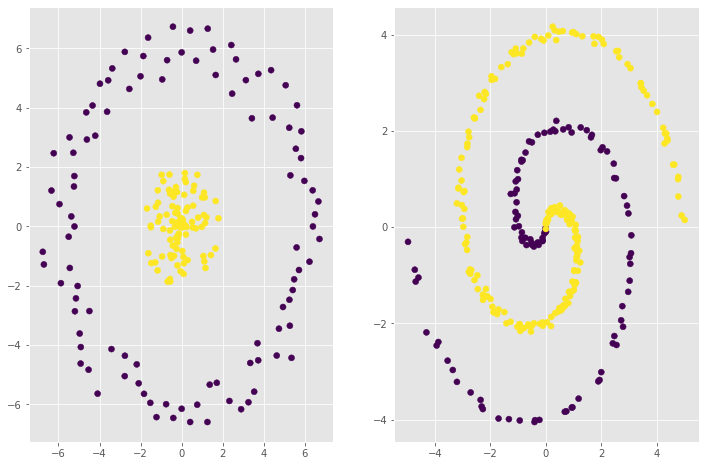

In [5]:
X_circle,y_circle = generate_dummy_circle_data(100)
plt.subplot(121)
plt.scatter(X_circle[:,0],X_circle[:,1],c=y_circle)

X_spiral,y_spiral = generate_dummy_spiral_data(100,2)
plt.subplot(122)
plt.scatter(X_spiral[:,0],X_spiral[:,1],c=y_spiral)

$X \in \mathbb{R}^{N,D}$ - like the multinomial logistic regression, our data is also represented as a matrix with $N$ rows and $D$ columns, where each row is a $D$-dimensional feature vector representing an instance / example in our dataset $(x_i \in \mathbb{R}^D)$. In this particular example, $D=2$.

$y \in \{0,..,C\}^N$ - Given $C$ distinct classes, the prediction target is represented as a vector of length $N$ and each example $y_i$ is a scalar that can take on a value from 0 to $C$.

**Note that the math expresses our target variable $y_i$ as a one-hot encoding vector, where it has a value of 1 corresponding to the correct class and 0 everywhere else. In practice, we represent $y_i$ as a scalar value denoting the index of the correct class instead. This is because it is not computationally and memory efficient to treat each $y_i$ as a vector, specially for large number of classes, when almost all of its values are 0.** 

In [6]:
print("The shape of X:", X_circle.shape)
print("The shape of y:", y_circle.shape)
print("\nFirst 5 examples:")
for i in range(5):
    print("X[{}] = {}\t y[{}] = {}".format(i, X_circle[i], i, y_circle[i]))

The shape of X: (200, 2)
The shape of y: (200,)

First 5 examples:
X[0] = [-0.42987855 -0.64571507]	 y[0] = 1
X[1] = [ 0.75894653 -6.00768042]	 y[1] = 0
X[2] = [-1.6867782   0.60434077]	 y[2] = 1
X[3] = [3.42328594 3.64542926]	 y[3] = 0
X[4] = [-0.1965121   0.43140486]	 y[4] = 1


# Neural Networks

###  Initialize Weights! We initialize the weights with small random values and the biases are initialized to zero.
Open `neural_networks.py`, and fill in the code for the function `initialize_weights`.

In [7]:
from neural_networks import NeuralNetwork

In [8]:
np.random.seed(1)
net = NeuralNetwork(hidden_size=6,num_classes=3)
net.initialize_weights(input_dim=5)

for param in net.params:
    print("Shape of",param, net.params[param].shape)

for param in net.params:
    print(param, net.params[param])

Shape of W1 (5, 6)
Shape of b1 (6,)
Shape of W2 (6, 3)
Shape of b2 (3,)
W1 [[ 0.01624345 -0.00611756 -0.00528172 -0.01072969  0.00865408 -0.02301539]
 [ 0.01744812 -0.00761207  0.00319039 -0.0024937   0.01462108 -0.02060141]
 [-0.00322417 -0.00384054  0.01133769 -0.01099891 -0.00172428 -0.00877858]
 [ 0.00042214  0.00582815 -0.01100619  0.01144724  0.00901591  0.00502494]
 [ 0.00900856 -0.00683728 -0.0012289  -0.00935769 -0.00267888  0.00530355]]
b1 [0. 0. 0. 0. 0. 0.]
W2 [[-0.00691661 -0.00396754 -0.00687173]
 [-0.00845206 -0.00671246 -0.00012665]
 [-0.0111731   0.00234416  0.01659802]
 [ 0.00742044 -0.00191836 -0.00887629]
 [-0.00747158  0.01692455  0.00050808]
 [-0.00636996  0.00190915  0.02100255]]
b2 [0. 0. 0.]


**Sanity Check:**
    
Expected Output
```
Shape of W1 (5, 6)
Shape of b1 (6,)
Shape of W2 (6, 3)
Shape of b2 (3,)
W1 [[ 0.01624345 -0.00611756 -0.00528172 -0.01072969  0.00865408 -0.02301539]
 [ 0.01744812 -0.00761207  0.00319039 -0.0024937   0.01462108 -0.02060141]
 [-0.00322417 -0.00384054  0.01133769 -0.01099891 -0.00172428 -0.00877858]
 [ 0.00042214  0.00582815 -0.01100619  0.01144724  0.00901591  0.00502494]
 [ 0.00900856 -0.00683728 -0.0012289  -0.00935769 -0.00267888  0.00530355]]
b1 [ 0.  0.  0.  0.  0.  0.]
W2 [[-0.00691661 -0.00396754 -0.00687173]
 [-0.00845206 -0.00671246 -0.00012665]
 [-0.0111731   0.00234416  0.01659802]
 [ 0.00742044 -0.00191836 -0.00887629]
 [-0.00747158  0.01692455  0.00050808]
 [-0.00636996  0.00190915  0.02100255]]
b2 [ 0.  0.  0.]
```

###  Implement forward pass of a Fully Connected Layer (Also often called affine, linear, or dense layer)
Open `neural_networks.py`, and fill in the code for the function `fully_connected_forward`.

In [9]:
np.random.seed(1)
net = NeuralNetwork(num_layers=2,num_classes=2, hidden_size=3)
net.initialize_weights(input_dim=2)

out, cache = net.fully_connected_forward(X_circle[:5],net.params['W1'], net.params['b1'])
print("Fully Connected Layer Output:")
print(out)

Fully Connected Layer Output:
[[-5.43922962e-05 -2.95825783e-03  1.71318792e-02]
 [ 7.67884387e-02 -5.66338288e-02  1.34260549e-01]
 [-3.38834903e-02  1.55489850e-02 -5.00005074e-03]
 [ 1.64916743e-02  1.06056517e-02 -1.01981795e-01]
 [-7.82087392e-03  4.93558593e-03 -8.89102840e-03]]


**Sanity Check:**
    
Expected Output
```
Fully Connected Layer Output:
[[ -5.43922962e-05  -2.95825783e-03   1.71318792e-02]
 [  7.67884387e-02  -5.66338288e-02   1.34260549e-01]
 [ -3.38834903e-02   1.55489850e-02  -5.00005074e-03]
 [  1.64916743e-02   1.06056517e-02  -1.01981795e-01]
 [ -7.82087392e-03   4.93558593e-03  -8.89102840e-03]]
```

###  Implement backward pass of a Fully Connected Layer.
Open `neural_networks.py`, and fill in the code for the function `fully_connected_backward`.

In [10]:
np.random.seed(1)
net = NeuralNetwork()
W1 = np.random.randn(2,5)
b1 = np.random.randn(5)
dUpper = np.random.randn(5, 5)

out, cache = net.fully_connected_forward(X_circle[:5],W1, b1)

dX, dW, db = net.fully_connected_backward(dUpper,cache)

dX_num = compute_numerical_gradient(lambda X: np.sum(dUpper*net.fully_connected_forward(X, W1, b1)[0])
                           , X_circle[:5])

dW_num = compute_numerical_gradient(lambda W: np.sum(dUpper*net.fully_connected_forward(X_circle[:5], W, b1)[0])
                           , W1)

db_num = compute_numerical_gradient(lambda b: np.sum(dUpper*net.fully_connected_forward(X_circle[:5],W1, b)[0])
                           ,  b1)

print("Gradient dX Relative Error",relative_error(dX, dX_num))
print("Gradient dW Relative Error",relative_error(dW, dW_num))
print("Gradient db Relative Error",relative_error(db, db_num))

Gradient dX Relative Error 1.6351637958423586e-10
Gradient dW Relative Error 5.4161801039518395e-09
Gradient db Relative Error 4.755027184008211e-11


**Sanity Check:**

The relative errors of the gradients should be less than $10^{-8}$. The values may vary depending on your implementation.

Largest Relative Errors in our implementation:
```
Gradient dX Relative Error 1.63516379584e-10
Gradient dW Relative Error 5.41617890346e-09
Gradient db Relative Error 5.70914573891e-11
```


### Implement the forward pass of the Sigmoid activation function
Open `neural_networks.py`, and fill in the code for the function `sigmoid_forward`.

In [11]:
np.random.seed(1)
net = NeuralNetwork()
out, cache = net.sigmoid_forward(np.random.randn(5,5))
print("Sigmoid Layer Output:")
print(out)

Sigmoid Layer Output:
[[0.83539354 0.35165864 0.3709434  0.25483894 0.70378922]
 [0.09099561 0.85129722 0.31838429 0.57909005 0.43797848]
 [0.81185487 0.11303172 0.42008677 0.40514941 0.75653387]
 [0.24976027 0.45699943 0.29362176 0.51055187 0.64171493]
 [0.2496239  0.75854586 0.71127629 0.62304533 0.71112537]]


**Sanity Check:**
    
Expected Output
```
Sigmoid Layer Output:
[[ 0.83539354  0.35165864  0.3709434   0.25483894  0.70378922]
 [ 0.09099561  0.85129722  0.31838429  0.57909005  0.43797848]
 [ 0.81185487  0.11303172  0.42008677  0.40514941  0.75653387]
 [ 0.24976027  0.45699943  0.29362176  0.51055187  0.64171493]
 [ 0.2496239   0.75854586  0.71127629  0.62304533  0.71112537]]

```

###  Implement the backward pass of the Sigmoid activation function
Open `neural_networks.py`, and fill in the code for the function `sigmoid_backward`.

In [12]:
np.random.seed(1)
net = NeuralNetwork()
dUpper = np.random.randn(5, 5)
dummy_input = np.random.randn(5,5)
out, cache = net.sigmoid_forward(dummy_input)

dSigmoid = net.sigmoid_backward(dUpper,cache)

dSigmoid_num = compute_numerical_gradient(lambda X: np.sum(dUpper*net.sigmoid_forward(X)[0])
                           , dummy_input)

print("Gradient dSigmoid Relative Error",relative_error(dSigmoid, dSigmoid_num))

Gradient dSigmoid Relative Error 2.823070352211863e-10


**Sanity Check:**

The relative errors of the gradients should be less than $10^{-8}$. The values may vary depending on your implementation.

Largest Relative Error in our implementation:
```
Gradient dSigmoid Relative Error 2.8230695697e-10
```


###  Implement softmax cross entropy loss layer
Lets first implement softmax function that converts raw scores to probabilities.

Open `neural_networks.py`, and fill in the code for the function `softmax`.

In [13]:
np.random.seed(1)
net = NeuralNetwork()
probs = net.softmax(np.array([[1001,1002,1003,1004,1005],[3,4,5,6,7]]))
print("Probabilities of belonging to each class")
print(probs)

Probabilities of belonging to each class
[[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
 [0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]]


**Sanity Check:**
    
Expected Output:
```
Probabilities of belonging to each class
[[ 0.01165623  0.03168492  0.08612854  0.23412166  0.63640865]
 [ 0.01165623  0.03168492  0.08612854  0.23412166  0.63640865]]
```

Next, implement the softmax cross entropy loss and compute for its gradients. Since this is applied in the last layer, we do not need to worry about the gradients coming from after this layer.

Open `neural_networks.py`, and fill in the code for the function `softmax_cross_entropy_loss`.

In [14]:
np.random.seed(1)
net = NeuralNetwork()
loss, dloss = net.softmax_cross_entropy_loss(np.random.randn(4,6),np.random.randint(0,6,size=4))
print("Softmax Cross-entropy Loss")
print(loss)
print()
print("Gradient of the loss with respect to the scores")
print(dloss)

Softmax Cross-entropy Loss
3.234301469279815

Gradient of the loss with respect to the scores
[[ 0.14058054  0.01502445  0.01633424  0.0094732   0.06581467 -0.24722709]
 [ 0.11190472  0.00913058  0.02689325 -0.23476698  0.0843474   0.00249103]
 [ 0.02967359 -0.22210018  0.12728696  0.01363695  0.03447541  0.01702727]
 [ 0.02501532  0.04295228 -0.24202226  0.07533903  0.0590784   0.03963723]]


**Sanity Check:**
    
Expected Output:
```
Softmax Cross-entropy Loss
3.23430146928

Gradient of the loss with respect to the scores
[[ 0.14058054  0.01502445  0.01633424  0.0094732   0.06581467 -0.24722709]
 [ 0.11190472  0.00913058  0.02689325 -0.23476698  0.0843474   0.00249103]
 [ 0.02967359 -0.22210018  0.12728696  0.01363695  0.03447541  0.01702727]
 [ 0.02501532  0.04295228 -0.24202226  0.07533903  0.0590784   0.03963723]]
```

###  Build a simple network!
Now that we have implemented two different types of layers, we can now build a simple neural network consisting of fully connected layers with relu activations.

We will follow a simple feed forward neural network architecture as shown below:
```
Repeat for (Number of layers - 1): 
    [Fully Connected Layer] 
    [Activation Layer]

[Fully Connected Layer] # (Output layer)
```

**Open `neural_networks.py`, and fill in the code for the function `network_forward`.**

In [30]:
np.random.seed(1)
net = NeuralNetwork(num_layers=2, num_classes=3, hidden_size=10, hidden_activation_fn="sigmoid")
net.initialize_weights(5,std_dev=0.1)

scores, cache_list  = net.network_forward(np.random.randn(5,5)*10)

print("Forward Pass:")
print(scores)

Forward Pass:
[[ 0.19910154 -0.11077738  0.24974865]
 [ 0.26508479 -0.18731063  0.24634693]
 [ 0.3482853  -0.25223747 -0.06853373]
 [ 0.30067375 -0.14904403  0.18594437]
 [ 0.20967705 -0.07065423  0.10956096]]


**Sanity Check:**
    
Expected Output:
```
Forward Pass:
[[ 0.19910154 -0.11077738  0.24974865]
 [ 0.26508479 -0.18731063  0.24634693]
 [ 0.3482853  -0.25223747 -0.06853373]
 [ 0.30067375 -0.14904403  0.18594437]
 [ 0.20967705 -0.07065423  0.10956096]]
```



### Compute for the losses corresponding to the current parameters.
Implement `loss` function which should output the losses as well as its the gradients. Note that the gradient computation of the layers is implemented in a separate function `network_backward` which you should also implement.

In [46]:
np.random.seed(1)
net = NeuralNetwork(num_layers=2,num_classes=2, hidden_size=10, hidden_activation_fn="sigmoid")
net.initialize_weights(input_dim=2, std_dev=0.5)
loss, grads = net.loss(X_circle[:5]*10, y_circle[:5], lambda_reg=0.0)
for param in net.params:
    f = lambda W: net.loss(X_circle[:5]*10, y_circle[:5], lambda_reg=0.0)[0]
    param_grad_num = compute_numerical_gradient(f, net.params[param])
    # Uncomment this if you want to print out the actual values for debugging.
    # print(param + "_numerical", param_grad_num)
    # print(param + "_analytical",grads[param])
    print('{} Relative Error: {}'.format(param, relative_error(param_grad_num, grads[param])))

W1 Relative Error: 1.0
b1 Relative Error: 1.0
W2 Relative Error: 1.0
b2 Relative Error: 1.0


The relative errors of the gradients should be less than $10^{-8}$. The values may vary depending on your implementation.

Largest Relative Errors in our implementation:
```
W1 Relative Error: 1.565689660633177e-08
b1 Relative Error: 8.285555392599544e-09
W2 Relative Error: 8.125385495575136e-11
b2 Relative Error: 2.0095447739463423e-11
```

In [47]:
np.random.seed(1)
X = X_circle
y = y_circle

net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=6, hidden_activation_fn="sigmoid")
loss_history = net.train(X, y, learning_rate=0.9, lambda_reg=0.0, num_iters=1000, batch_size=10, verbose=False)

Text(0, 0.5, 'Loss')

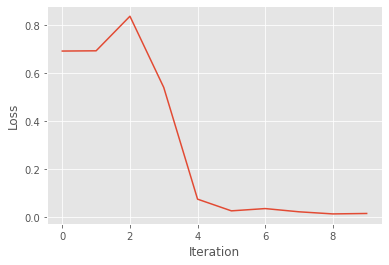

In [48]:
%matplotlib inline
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [49]:
Y_train_pred = net.predict(X)
print("Train accuracy: {} %".format(np.mean(Y_train_pred == y) * 100))

Train accuracy: 100.0 %


# Let's visualize the training process!
The code below will visualize the decision boundary (left) and the transformations (right) that the network learned during training.

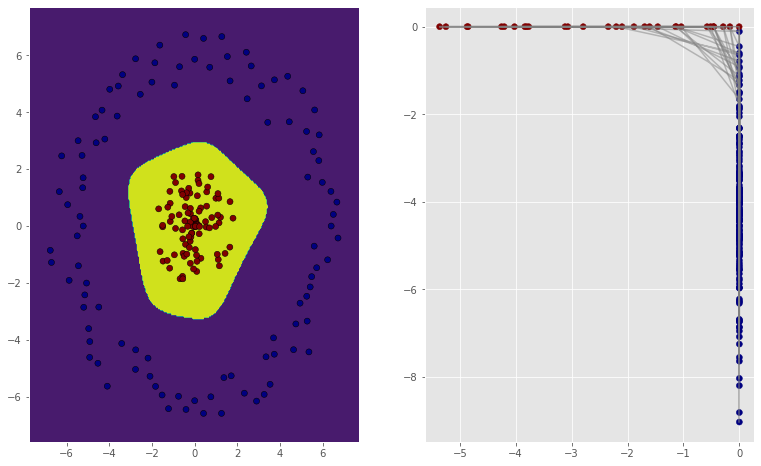

In [52]:
%matplotlib inline 
net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=6, hidden_activation_fn="sigmoid")
net.initialize_weights(X.shape[1],1)
fig = plt.figure(figsize=(13,8))
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))


x1, y1 = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

grid_x = np.squeeze(np.stack((x1.ravel(),y1.ravel()))).T
x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(300):
    
    net.train_step(X, y, learning_rate=1, lambda_reg=0.0, batch_size=10)
    if i % 10 == 0:

        Z = net.predict(x_test)

        Z = Z.reshape(xx.shape)
        ax1.clear()
        ax1.contourf(xx, yy, Z)
        ax1.scatter(X[:, 0], X[:, 1], c = y,cmap="jet", edgecolors='black')
        
        Z, sc= net.predict(grid_x, return_scores=True)

        ax2.clear()
        for i in range(12):
            ax2.plot(sc[i*x1.shape[0]:(i+1)*x1.shape[0],0],sc[i*x1.shape[0]: (i+1)*x1.shape[0],1], "gray", alpha=0.5)
            ax2.plot(sc[np.arange(i,x1.shape[1]**2,x1.shape[1]),0],sc[np.arange(i,x1.shape[1]**2,x1.shape[1]),1], "gray", alpha=0.5)
        ax2.scatter(sc[:,0],sc[:,1], c = Z, cmap="jet")
        
        fig.canvas.draw()

# Let's try other activation functions and see how it affects the model!

### Implement the forward pass of the Tanh activation function
Open `neural_networks.py`, and fill in the code for the function `tanh_forward`.

In [53]:
np.random.seed(1)
net = NeuralNetwork()
out, cache = net.tanh_forward(np.random.randn(5,5))
print("Tanh Layer Output:")
print(out)

Tanh Layer Output:
[[ 0.92525207 -0.5453623  -0.48398233 -0.79057703  0.69903334]
 [-0.98015695  0.94078216 -0.6417873   0.30863781 -0.24432671]
 [ 0.89806123 -0.96803916 -0.31169093 -0.36622326  0.81230541]
 [-0.80045996 -0.17073944 -0.70534482  0.04218869  0.52470857]
 [-0.80072132  0.8159986   0.71707154  0.46407656  0.71671439]]


**Sanity Check:**
    
Expected Output
```
Tanh Layer Output:
[[ 0.92525207 -0.5453623  -0.48398233 -0.79057703  0.69903334]
 [-0.98015695  0.94078216 -0.6417873   0.30863781 -0.24432671]
 [ 0.89806123 -0.96803916 -0.31169093 -0.36622326  0.81230541]
 [-0.80045996 -0.17073944 -0.70534482  0.04218869  0.52470857]
 [-0.80072132  0.8159986   0.71707154  0.46407656  0.71671439]]

```

###  Implement the backward pass of the Tanh activation function
Open `neural_networks.py`, and fill in the code for the function `tanh_backward`.

In [54]:
np.random.seed(1)
net = NeuralNetwork()
dUpper = np.random.randn(5, 5)
dummy_input = np.random.randn(5,5)
out, cache = net.tanh_forward(dummy_input)

dTanh = net.tanh_backward(dUpper,cache)

dTanh_num = compute_numerical_gradient(lambda X: np.sum(dUpper*net.tanh_forward(X)[0])
                           , dummy_input)

print("Gradient dTanh Relative Error",relative_error(dTanh, dTanh_num))

Gradient dTanh Relative Error 1.4881740475537487e-09


**Sanity Check:**

The relative errors of the gradients should be less than $10^{-8}$. The values may vary depending on your implementation.

Largest Relative Error in our implementation:
```
Gradient dTanh Relative Error 1.48817404755e-09
```


## Let's visualize the decision boundaries and transformations under Tanh Activations

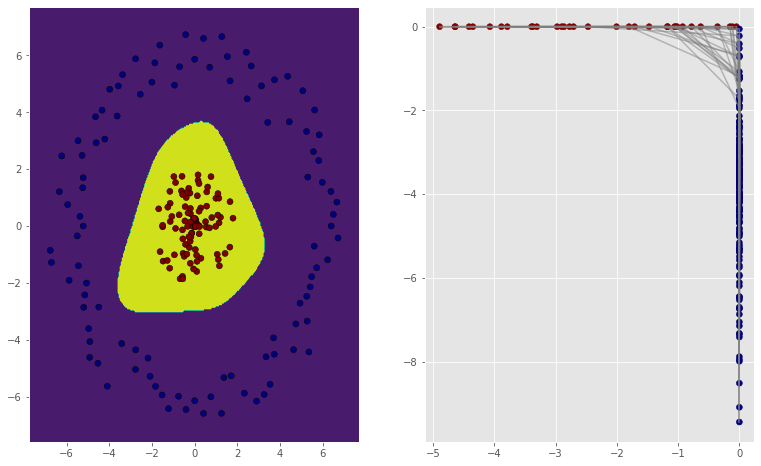

In [55]:
net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=6, hidden_activation_fn="tanh")
net.initialize_weights(X.shape[1],1)
fig = plt.figure(figsize=(13,8))
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))


x1, y1 = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

grid_x = np.squeeze(np.stack((x1.ravel(),y1.ravel()))).T
x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(300):
    
    net.train_step(X, y, learning_rate=1, lambda_reg=0.0, batch_size=10)
    if i % 10 == 0:

        Z = net.predict(x_test)

        Z = Z.reshape(xx.shape)
        ax1.clear()
        ax1.contourf(xx, yy, Z)
        ax1.scatter(X[:, 0], X[:, 1], c = y,cmap="jet", edgecolors='black')
        
        Z, sc= net.predict(grid_x, return_scores=True)

        ax2.clear()
        for i in range(12):
            ax2.plot(sc[i*x1.shape[0]:(i+1)*x1.shape[0],0],sc[i*x1.shape[0]: (i+1)*x1.shape[0],1], "gray", alpha=0.5)
            ax2.plot(sc[np.arange(i,x1.shape[1]**2,x1.shape[1]),0],sc[np.arange(i,x1.shape[1]**2,x1.shape[1]),1], "gray", alpha=0.5)
        ax2.scatter(sc[:,0],sc[:,1], c = Z, cmap="jet")
        
        fig.canvas.draw()

###  Implement the forward pass of ReLU
Open `neural_networks.py`, and fill in the code for the function `relu_forward`.

In [56]:
np.random.seed(1)
net = NeuralNetwork()
out, cache = net.relu_forward(np.random.randn(5,5))
print("ReLU Layer Output:")
print(out)

ReLU Layer Output:
[[1.62434536 0.         0.         0.         0.86540763]
 [0.         1.74481176 0.         0.3190391  0.        ]
 [1.46210794 0.         0.         0.         1.13376944]
 [0.         0.         0.         0.04221375 0.58281521]
 [0.         1.14472371 0.90159072 0.50249434 0.90085595]]


**Sanity Check:**
    
Expected Output
```
ReLU Layer Output:
[[ 1.62434536  0.          0.          0.          0.86540763]
 [ 0.          1.74481176  0.          0.3190391   0.        ]
 [ 1.46210794  0.          0.          0.          1.13376944]
 [ 0.          0.          0.          0.04221375  0.58281521]
 [ 0.          1.14472371  0.90159072  0.50249434  0.90085595]]
```

###  Implement the backward pass of ReLU
Open `neural_networks.py`, and fill in the code for the function `relu_backward`.

In [57]:
np.random.seed(1)
net = NeuralNetwork()
dUpper = np.random.randn(5, 5)
dummy_input = np.random.randn(5,5)
out, cache = net.relu_forward(dummy_input)

dRelu = net.relu_backward(dUpper,cache)

dRelu_num = compute_numerical_gradient(lambda X: np.sum(dUpper*net.relu_forward(X)[0])
                           , dummy_input)

print("Gradient dRelu Relative Error",relative_error(dRelu, dRelu_num))

Gradient dRelu Relative Error 5.718581028847127e-11


**Sanity Check:**

The relative errors of the gradients should be less than $10^{-8}$. The values may vary depending on your implementation.

Largest Relative Error in our implementation:
```
Gradient dRelu Relative Error 5.71858102885e-11
```


## Let's visualize the decision boundaries and transformations under ReLU Activations

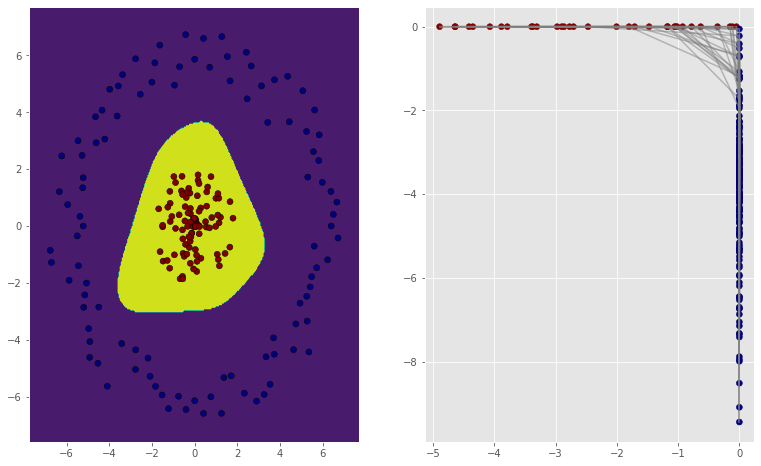

In [58]:
net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=6, hidden_activation_fn="relu")
net.initialize_weights(X.shape[1],1)
fig = plt.figure(figsize=(13,8))
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))


x1, y1 = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

grid_x = np.squeeze(np.stack((x1.ravel(),y1.ravel()))).T
x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(300):
    
    net.train_step(X, y, learning_rate=1, lambda_reg=0.0, batch_size=10)
    if i % 10 == 0:

        Z = net.predict(x_test)

        Z = Z.reshape(xx.shape)
        ax1.clear()
        ax1.contourf(xx, yy, Z)
        ax1.scatter(X[:, 0], X[:, 1], c = y,cmap="jet", edgecolors='black')
        
        Z, sc= net.predict(grid_x, return_scores=True)

        ax2.clear()
        for i in range(12):
            ax2.plot(sc[i*x1.shape[0]:(i+1)*x1.shape[0],0],sc[i*x1.shape[0]: (i+1)*x1.shape[0],1], "gray", alpha=0.5)
            ax2.plot(sc[np.arange(i,x1.shape[1]**2,x1.shape[1]),0],sc[np.arange(i,x1.shape[1]**2,x1.shape[1]),1], "gray", alpha=0.5)
        ax2.scatter(sc[:,0],sc[:,1], c = Z, cmap="jet")
        
        fig.canvas.draw()

## We can compare the loss curves across the different activation functions

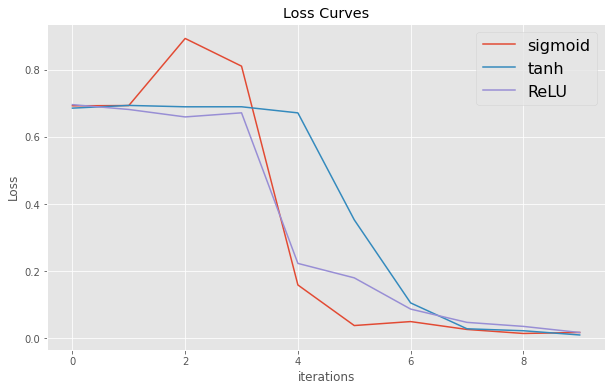

In [59]:
np.random.seed(1)
net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=6, hidden_activation_fn="sigmoid")
loss_history_sigmoid = net.train(X, y, learning_rate=0.8, lambda_reg=0.0, num_iters=1000, batch_size=10, verbose=False)

net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=6, hidden_activation_fn="tanh")
loss_history_tanh = net.train(X, y, learning_rate=0.8, lambda_reg=0.0, num_iters=1000, batch_size=10, verbose=False)

net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=6, hidden_activation_fn="relu")
loss_history_relu = net.train(X, y, learning_rate=0.8, lambda_reg=0.0, num_iters=1000, batch_size=10, verbose=False)

%matplotlib inline

plt.figure(figsize=(10,6))
sig = plt.plot(loss_history_sigmoid, label='sigmoid')
vl = plt.plot(loss_history_tanh, label='tanh')
relu = plt.plot(loss_history_relu, label='ReLU')

plt.title('Loss Curves')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend(prop={'size': 16})
plt.show()

## We can also see how the size of the hidden layer affects the decision boundary. Let's start with sigmoid activations.

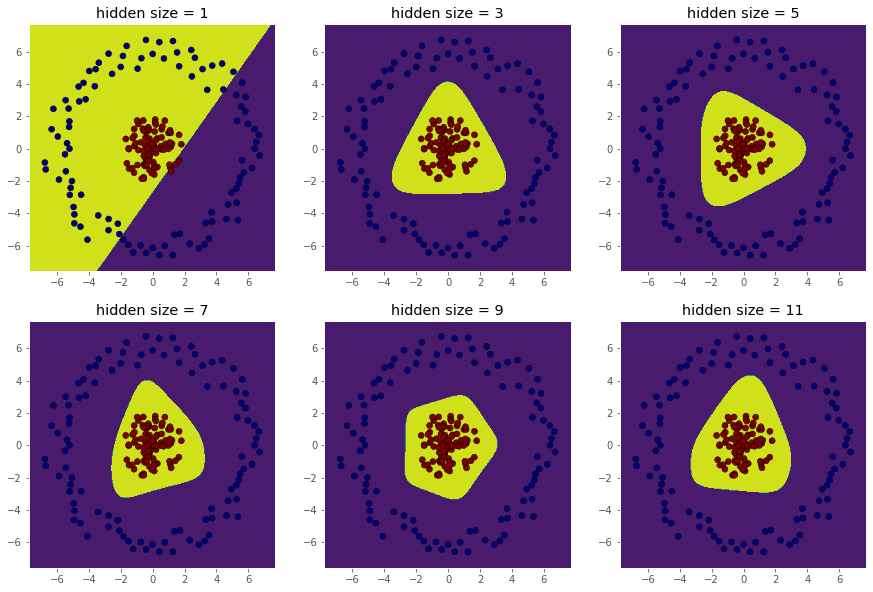

In [60]:
np.random.seed(2)
plt_ctr = 1
plt.figure(figsize=(15,10))
for h_size in range(1,13, 2):
    net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=h_size, hidden_activation_fn="sigmoid")
    loss_history_sigmoid = net.train(X, y, learning_rate=1, lambda_reg=0.0, num_iters=1000, batch_size=10, verbose=False)
    
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T
    
    Z = net.predict(x_test).reshape(xx.shape)
    plt.subplot(2,3,plt_ctr)
    plt.contourf(xx, yy, Z)
    plt.scatter(X[:, 0], X[:, 1], c = y,cmap="jet", edgecolors='black')
    plt.title("hidden size = "+str(h_size))
    plt_ctr += 1

plt.show()

## Tanh activations

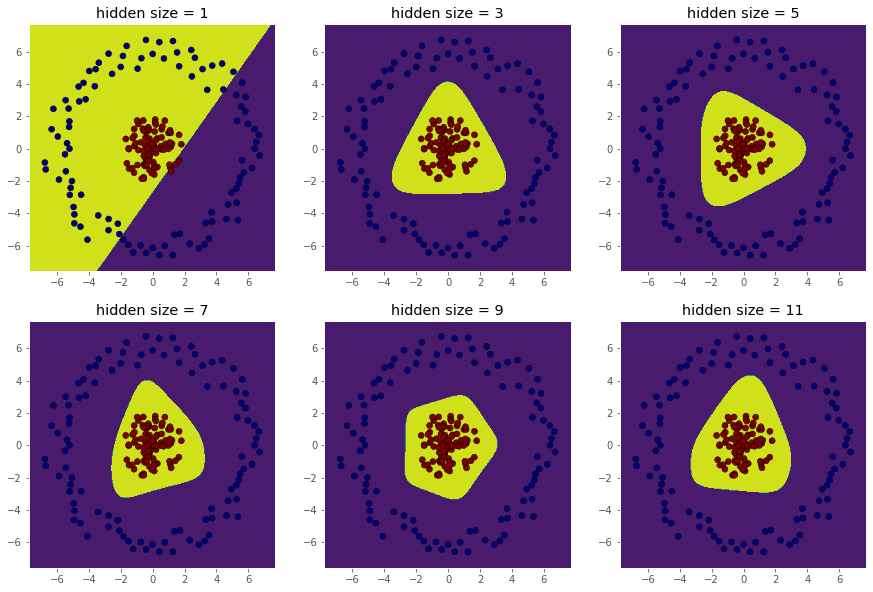

In [61]:
np.random.seed(2)
plt_ctr = 1
plt.figure(figsize=(15,10))
for h_size in range(1,13, 2):
    net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=h_size, hidden_activation_fn="tanh")
    loss_history_sigmoid = net.train(X, y, learning_rate=1, lambda_reg=0.0, num_iters=1000, batch_size=10, verbose=False)
    
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T
    
    Z = net.predict(x_test).reshape(xx.shape)
    plt.subplot(2,3,plt_ctr)
    plt.contourf(xx, yy, Z)
    plt.scatter(X[:, 0], X[:, 1], c = y,cmap="jet", edgecolors='black')
    plt.title("hidden size = "+str(h_size))
    plt_ctr += 1

plt.show()

## ReLU activations

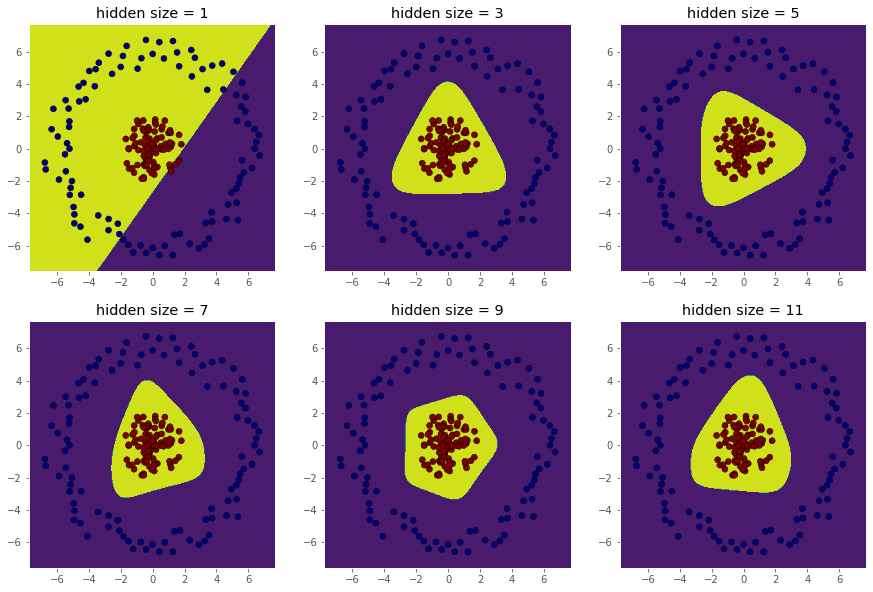

In [62]:
np.random.seed(2)
plt_ctr = 1
plt.figure(figsize=(15,10))
for h_size in range(1,13, 2):
    net = NeuralNetwork(num_layers=2, num_classes=2, hidden_size=h_size, hidden_activation_fn="relu")
    loss_history_sigmoid = net.train(X, y, learning_rate=1, lambda_reg=0.0, num_iters=1000, batch_size=10, verbose=False)
    
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T
    
    Z = net.predict(x_test).reshape(xx.shape)
    plt.subplot(2,3,plt_ctr)
    plt.contourf(xx, yy, Z)
    plt.scatter(X[:, 0], X[:, 1], c = y,cmap="jet", edgecolors='black')
    plt.title("hidden size = "+str(h_size))
    plt_ctr += 1

plt.show()

## <center>fin</center>



<sup>made/compiled by daniel stanley tan & courtney anne ngo 🐰 & thomas james tiam-lee</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> danieltan07@gmail.com & courtneyngo@gmail.com & thomasjamestiamlee@gmail.com</sup><br>
<sup>please cc your instructor, too</sup>
<!-- DO NOT MODIFY OR DELETE THIS -->
